# <font color='darkred'>Data Cleaning and preparations </font>
---
**This notebook will:**
- Import raw data and clean it
- Create two variables:
    * **Difference in ranking**
    * **Expected goals in the match**
    
- Explain three different **visualizations**
- Return the dataframe as a .csv file to be opened in the model notebook

---
The overall methodology I have used in this notebook is the following. 
- Import all game-tables and removed all excessive columns. 
- Create variables by using dictionaries from last years table
- For the teams that has been promoted i provided a score for them based on how the worst team performed last year
- For 2017, I added 0 to the columns for the variables I created since I have no data from 2016 to help calculate  
- I created some visualizations for the variables I believe will have the highest impact:
    - Do the team play Home or Away (**Bar plot**)
    - Difference in ranking between the two teams with how many goals they score (**Scatter plot**)
    - How many Goals the team scored + how many Goals the opponent conceded last year in total with how many goals they scored (**Scatter plot**)
---
When I created the variables, I created them seperately for each year, before I stacked them. If I had done the task again, I probably would have studied a way to make this more automatic. 

**Importing relevant packages**

In [4]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---
**Reading in html-files**

In [5]:
# Reading in table-dataframes
table_17 = pd.read_html('17_table.xls', encoding = "UTF8")
table_17 = DataFrame(table_17[0])

table_18 = pd.read_html('18_table.xls', encoding = "UTF8")
table_18 = DataFrame(table_18[0])

table_19 = pd.read_html('19_table.xls', encoding = "UTF8")
table_19 = DataFrame(table_19[0])

#Reading the games-dataframes
games_17 = pd.read_html('17_games.xls', encoding = "UTF8")
games_18 = pd.read_html('18_games.xls', encoding = "UTF8")
games_19 = pd.read_html('19_games.xls', encoding = "UTF8")
games_20 = pd.read_html('20_games.xls', encoding = "UTF8")

### Cleaning the games-files
**Firstly, converting the html-files to dataframes, before removing the irrelevant columns that 2020 does not have data for.**

In [6]:
games_20 = DataFrame(games_20[0])
#Creating a function to run the tables through. Had trouble with iterating over the dataframes with a for-loop.
def initial_cleaning(dataframe):
    dataframe = DataFrame(dataframe[0])
    dataframe = dataframe.drop(['Match Report', 'Notes', 'Referee', 'Attendance', 'Day'], axis = 1)
    return dataframe

# Cleaning
games_17 = initial_cleaning(games_17)
games_18 = initial_cleaning(games_18)
games_19 = initial_cleaning(games_19)

games_19 = games_19.drop(['Round'], axis = 1) #only table with 'round', and it does not give any important info
# Creating 0-values for Score in games_20 to make all tables alike
games_20['Score'] = str('0–0')


### **More cleaning of the dataframe where the steps are done for all years**

**Here I remove some columns, and delete empty rows. These are the rows in the file that are between the different rounds. I am dropping for 'Home', which means that there are no team to predict the score for, and I will not accidentally drop any relevant rows.**

In [7]:
# Creating a function that cleans the dataframe so that I don't have to do the same things for each

def further_cleaning(dataframe): 
    #deleting the first columns of what seems very unnecessary
    dataframe = dataframe.drop(['Wk', 'Time'], axis = 1)
    
    #dropping the empty rows which will create error
    dataframe = dataframe.dropna(subset = ['Home'])

    #changing obj to date_time
    dataframe['Date'] =  pd.to_datetime(dataframe['Date'])
    
    #Splitting the score
    dataframe[['Score_home','Score_away']] = dataframe['Score'].str.split('–', expand = True)
    cols = dataframe[['Score_home','Score_away']]
    dataframe[['Score_home','Score_away']] = dataframe[['Score_home','Score_away']].astype(int)
    return dataframe

games_17 = further_cleaning(games_17)
games_18 = further_cleaning(games_18)
games_19 = further_cleaning(games_19)
games_20 = further_cleaning(games_20)

# <font color='darkred'>Creating variables</font>
___
## Variable nr. 1: Difference in placement on last year's table

**The first variable I create is the away team ranking - the home team ranking on last year's table. I have done this by creating a dictionary where squad and ranking are zipped together, and used to provide the rankings for the two teams that play. They are then subtracted to get the variable.**

In [8]:
table_17.Squad

0        LSK Kvinner
1          Avaldsnes
2             Stabæk
3              Klepp
4                Røa
5       Arna-Bjørnar
6          Vålerenga
7     Trondheims-Ørn
8          Sandviken
9            Kolbotn
10        Grand Bodø
11           Medkila
Name: Squad, dtype: object

In [9]:
table_17.Rk

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
Name: Rk, dtype: int64

In [5]:
## Creating dictionaries and functions for the variable

# This dictionary takes the team and its ranking from one year
rank_17 = dict(zip(table_17.Squad, table_17.Rk)) # The rankings in 2017 --> to be used in 2018 table
rank_18 = dict(zip(table_18.Squad, table_18.Rk)) # The rankings in 2018 --> to be used in 2019 table
rank_19 = dict(zip(table_19.Squad, table_19.Rk)) # The rankings in 2019 --> to be used in 2020 table

#This is just a function to provide a fair ranking for the teams that have been promoted to the league this season
# Since they were just promoted, they will be assigned 
def provide_score_17(Lag):
    if Lag not in rank_17:
        rank_17[Lag] = 12
    return rank_17[Lag]

def provide_score_18(Lag):
    if Lag not in rank_18:
        rank_18[Lag] = 12
    return rank_18[Lag]

def provide_score_19(Lag):
    if Lag not in rank_19:
        rank_19[Lag] = 12
    return rank_19[Lag]

**Below i create the new columns**

In [6]:
# Creating columns that calculates the difference in score between the two teams
# Firstly I add two columns with the score of each team, and then I calculate the difference in score

for i in ["Rank diff", "Rank diff away", "Rating_home","Rating_away"]: # makes the columns stackable
    games_17[i] = 0

# for 2018
games_18["Rating_home"] = games_18.Home.apply(provide_score_17)
games_18["Rating_away"] = games_18.Away.apply(provide_score_17)
games_18["Rank diff"] = -(games_18["Rating_home"] - games_18["Rating_away"])
games_18["Rank diff away"] = (games_18["Rating_home"] - games_18["Rating_away"])

# for 2019
games_19["Rating_home"] = games_19.Home.apply(provide_score_18)
games_19["Rating_away"] = games_19.Away.apply(provide_score_18)
games_19["Rank diff"] = -(games_19["Rating_home"] - games_19["Rating_away"])
games_19["Rank diff away"] = (games_19["Rating_home"] - games_19["Rating_away"])

#For 2020
games_20["Rating_home"] = games_20.Home.apply(provide_score_19)
games_20["Rating_away"] = games_20.Away.apply(provide_score_19)
games_20["Rank diff"] = -(games_20["Rating_home"] - games_20["Rating_away"])
games_20["Rank diff away"] = (games_20["Rating_home"] - games_20["Rating_away"])

---
## <font color='#045F00'>Variable nr. 2: number of goals the team has scored last season + number of goals the opponent has conceded last season</font>


**This variable uses the same procedure as the other variable, but here I am interested in how many goals the team has scored, and how many goals each team has conceded last year. I then add the goals scored of team I will predict with the goals conceded of its opponent.**

In [7]:
# Dictionaries matching the team with number of goals scored last season
gf_17 = dict(zip(table_17.Squad, table_17.GF))
gf_18 = dict(zip(table_18.Squad, table_18.GF))
gf_19 = dict(zip(table_19.Squad, table_19.GF))

# Dictionaries matching the team with number of goals conceded last season
ga_17 = dict(zip(table_17.Squad, table_17.GA))
ga_18 = dict(zip(table_18.Squad, table_18.GA))
ga_19 = dict(zip(table_19.Squad, table_19.GA))

In [8]:
##Creating a column for total of goals Team has scored + Opponent has conceded##

#Creating the functions to get the 'Goals' from table_17, 18 and 19
def hent_gf_17(Lag):
    a = min(gf_17)
    if Lag not in gf_17:
        gf_17[Lag] = gf_17[a]
    return gf_17[Lag]

def hent_gf_18(Lag):
    a = min(gf_18)
    if Lag not in gf_18:
        gf_18[Lag] = gf_18[a]
    return gf_18[Lag]

def hent_gf_19(Lag):
    a = min(gf_19)
    if Lag not in gf_19:
        gf_19[Lag] = gf_19[a]
    return gf_19[Lag]

In [9]:
#Creating the functions to get the 'Goals against' from table_17, 18 and 19
def hent_ga_17(Lag):
    a = max(ga_17)
    if Lag not in ga_17:
        ga_17[Lag] = ga_17[a]
    return ga_17[Lag]

def hent_ga_18(Lag):
    a = max(ga_18)
    if Lag not in ga_18:
        ga_18[Lag] = ga_18[a]
    return ga_18[Lag]

def hent_ga_19(Lag):
    a = max(ga_19)
    if Lag not in ga_19:
        ga_19[Lag] = ga_19[a]
    return ga_19[Lag]

**As in the previous variable, I add null values for 2017**

In [10]:

for i in ["Goals_home", "Goals_away", "Goals expected", "Goals expected away", "Goalsagainst_home", "Goalsagainst_away"]:
    games_17[i] = 0

games_18["Goals_home"] = games_18.Home.apply(hent_gf_17)
games_18["Goals_away"] = games_18.Away.apply(hent_gf_17)
games_18["Goalsagainst_home"] = games_18.Home.apply(hent_ga_17)
games_18["Goalsagainst_away"] = games_18.Away.apply(hent_ga_17)
games_18["Goals expected"] = (games_18["Goals_home"] + games_18["Goalsagainst_away"])
games_18["Goals expected away"] = (games_18["Goals_away"] + games_18["Goalsagainst_home"])

games_19["Goals_home"] = games_19.Home.apply(hent_gf_18)
games_19["Goals_away"] = games_19.Away.apply(hent_gf_18)
games_19["Goalsagainst_home"] = games_19.Home.apply(hent_ga_18)
games_19["Goalsagainst_away"] = games_19.Away.apply(hent_ga_18)
games_19["Goals expected"] = (games_19["Goals_home"] + games_19["Goalsagainst_away"])
games_19["Goals expected away"] = (games_19["Goals_away"] + games_19["Goalsagainst_home"])

# I will add for games 20 later
games_20["Goals_home"] = games_20.Home.apply(hent_gf_19)
games_20["Goals_away"] = games_20.Away.apply(hent_gf_19)
games_20["Goalsagainst_home"] = games_20.Home.apply(hent_ga_19)
games_20["Goalsagainst_away"] = games_20.Away.apply(hent_ga_19)
games_20["Goals expected"] = (games_20["Goals_home"] + games_20["Goalsagainst_away"])
games_20["Goals expected away"] = (games_20["Goals_away"] + games_20["Goalsagainst_home"])

**After I have done the cleaning, I concatenate the models to give a brief overview of how the table looks like after initial cleaning.**

In [11]:
# Concatenating
games_years = (games_17, games_18, games_19, games_20)

# Creating the contatenated dataframe
games = pd.concat(games_years, ignore_index=True)

# This is so I can drop 2017 only for the visualization where 2017 have a lot of null values
games_visual = pd.concat(games_years, ignore_index=True)

# Table for the time being:
games.tail(3)

,Date,Home,Score,Away,Venue,Score_home,Score_away,Rank diff,Rank diff away,Rating_home,Rating_away,Goals_home,Goals_away,Goals expected,Goals expected away,Goalsagainst_home,Goalsagainst_away
487,2020-12-06,Sandviken,0–0,Avaldsnes,Stemmemyren kunstgressbane,0,0,1,-1,4,5,43,40,76,72,32,33
488,2020-12-06,LSK Kvinner,0–0,Lyn,LSK-hallen,0,0,9,-9,1,10,51,23,88,41,18,37
489,2020-12-06,Vålerenga,0–0,Arna-Bjørnar,Vålerenga kultur- og idrettspark kunstgr...,0,0,7,-7,2,9,41,26,82,50,24,41


**Concatenating the tables before splitting each row into two**

In [12]:
# Concatenating
games = pd.concat(games_years, ignore_index=True)

In [13]:
# Adding season to be able to drop and separate for season in model building
games['Season'] = games['Date'].dt.year

### Splitting each row into two rows

In [14]:
# Creating Match ID
games["Match ID"] = range(1, 1+len(games))
#Creating a new column to take the variable home or away according to if their match is on homeground or awayground
games["Home_Away"] = "Home"

#Duplicate each row for planning to only predict the score of 1 team
games = games.loc[games.index.repeat(2),:].reset_index(drop=True)
#create a variable to call only the duplicate or the original with true/false
games_duplicate = games.duplicated(keep="first")
#Calls the duplicates "away"
games.loc[games_duplicate,"Home_Away"] = "Away"
#arranges the column values from Score_away to fit in score_home, I will later change the name of this to only "score", and changes the order of the teams so that i have one column with team to predict and one with opponent
games.loc[games_duplicate, ["Score_home", "Away", "Home", "Rank diff", "Rating_home", "Goals expected"]] = games.loc[games_duplicate, ["Score_away", "Home","Away", "Rank diff away", "Rating_away", "Goals expected away"]].to_numpy()

# Removing unimporatant columns
games = games.drop(['Score', "Score_away" ], axis = 1)

#Renaming  columns
games.rename(columns={"Home" : "Team",
"Away" : "Opponent",
"Score_home" : "Goals"}, inplace=True)

games_visual = games.loc[(games['Season'] != 2017)]


**Creating normalized values for my variables**

In [15]:
#Normalized expected goals and ranking
games['GE_N'] = (games['Goals expected']-games['Goals expected'].min())/(games['Goals expected'].max()-games['Goals expected'].min())
games['Rk_N'] = (games['Rank diff']-games['Rank diff'].min())/(games['Rank diff'].max()-games['Rank diff'].min())

# <font color='darkred'>Visualizations</font>

### Home-advantage?

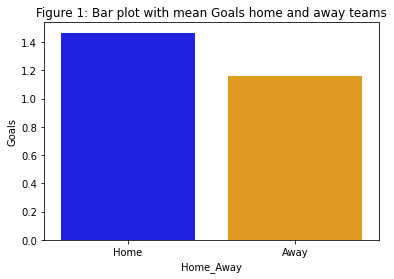

In [16]:
#Bar plot over mean goals scored home and away
colors = ['blue', 'orange']
figure_1 = sns.barplot(x = 'Home_Away', y = "Goals", data = games, ci = False, 
                       palette = colors).set_title("Figure 1: Bar plot with mean Goals home and away teams")




**As we can see the 'Home' team scores on average more goals (about 1.5), than the 'Away' Team (about 1.1).**

## Variables
---
**We can study the effect of each variable**
### <font color='Darkblue'> Ranking Variable</font>

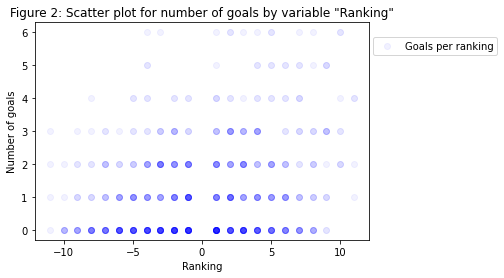

In [17]:
plt.scatter(x = games_visual['Rank diff'], y = games_visual['Goals'], alpha = 0.05, color = 'blue', label = 'Goals per ranking')
plt.ylabel('Number of goals')
plt.xlabel('Ranking')
plt.title('Figure 2: Scatter plot for number of goals by variable "Ranking"')
plt.legend(loc=(1.01,0.85))

<font color='Darkblue'> **This Figure shows the relationship between the variable ranking (normalized), that shows the difference in placement on the table last year for the team vs the opponent, and number of goals actually scored. In this Figure we can see that there are more action going on in the top right corner and the bottom left corner than on the other sides. I have put alpha to 0.1 so that the clusters of observations in the bottom left is clearly shown**</font>

### <font color='green'> Goals Expected Variable</font>

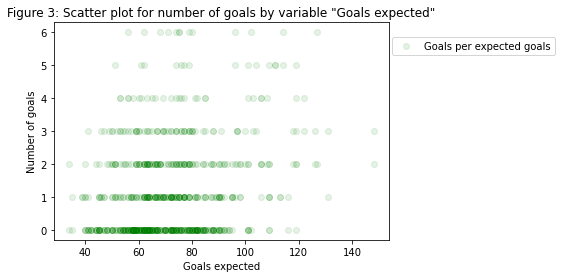

In [18]:
colors= {'Home' : 'red', 'Away': 'blue'}
plt.scatter(x = games_visual['Goals expected'], y = games_visual['Goals'], alpha = 0.1, color = 'green', label = 'Goals per expected goals')
plt.ylabel('Number of goals')
plt.xlabel('Goals expected')
plt.title('Figure 3: Scatter plot for number of goals by variable "Goals expected"')
plt.legend(loc=(1.01,0.85))

<font color='green'>**This Figure shows the relationship between the variable Goals expected, and number of goals actually scored. In this Figure we can see that there are more action going on in the bottom left corner and that the tendency is that it is slowly moving towards top right corner. I have put alpha to 0.1 so that the clusters of observations in the bottom left is clearly shown**</font>

---
**The final cleaning of the data I only choose the relevant variables to export to the model selection**

In [19]:
#Choosing relevant columns
cols = ['Match ID', 'Season', 'Team', 'Opponent', 'Home_Away', 'GE_N', 'Rk_N', 'Goals']
games = games[cols]

In [20]:
games.to_csv("cleaned_data.csv", index = False)
games

,Match ID,Season,Team,Opponent,Home_Away,GE_N,Rk_N,Goals
0,1,2017,Medkila,Sandviken,Home,0.000000,0.500000,1
1,1,2017,Sandviken,Medkila,Away,0.000000,0.500000,1
2,2,2017,Avaldsnes,Vålerenga,Home,0.000000,0.500000,2
3,2,2017,Vålerenga,Avaldsnes,Away,0.000000,0.500000,1
4,3,2017,Grand Bodø,Arna-Bjørnar,Home,0.000000,0.500000,2
...,...,...,...,...,...,...,...,...
975,488,2020,Avaldsnes,Sandviken,Away,0.486486,0.454545,0
976,489,2020,LSK Kvinner,Lyn,Home,0.594595,0.909091,0
977,489,2020,Lyn,LSK Kvinner,Away,0.277027,0.090909,0
978,490,2020,Vålerenga,Arna-Bjørnar,Home,0.554054,0.818182,0


---
**IMPORTANT INPUT REGARDING NOT CREATING VARIABLES FOR PLAYER STATISTICS:**


**I have avoided using player statistics to create variables since football matches have such a high degree of randomness to a score. I therefore wanted my model to be as simple and precise as possible. I did not find any variables for player statistics that I believe would have made such an important impact that it would be worth making the model more prone to overfitting. 
Still, some of the variables I have considered were these:**

- Ranking of the top 14 players of the team I am to predict score for (11 players + 3 substitutes)
    - This could have been even more advanced by selecting 1 keeper, top 5 defenders, top 5 midfielders and top 3 strikers
- Mean age 
- Ranking best player